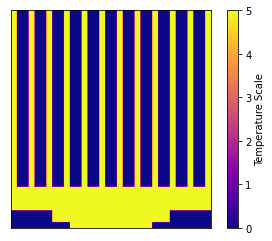

T:     pr     |     cs     |      hs      |
 5.000053254534324 4.999999699745617 4.999999917672185


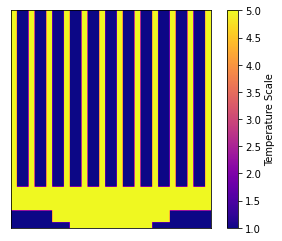


Average T, difference from 1000 runs ago:
 5.0000012594885614 3.9940562471229235
T:     pr     |     cs     |      hs      |
 5.010640920845753 5.002812883671174 4.99991972280366


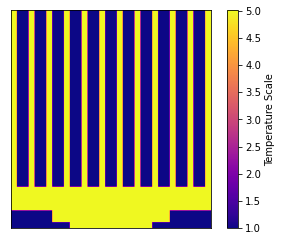


Average T, difference from 1000 runs ago:
 5.000403037726005 0.0004017782374434731
T:     pr     |     cs     |      hs      |
 5.015210248059164 5.00557240511853 4.99988036896841


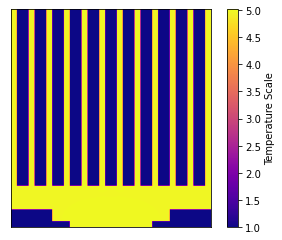


Average T, difference from 1000 runs ago:
 5.0006845503380015 0.0002815126119966038
T:     pr     |     cs     |      hs      |
 5.01846048944524 5.007917308845031 4.999765309237131


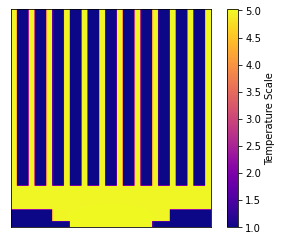


Average T, difference from 1000 runs ago:
 5.000834059250276 0.00014950891227449858
T:     pr     |     cs     |      hs      |
 5.021154289598105 5.0100481117959035 4.999621806251611


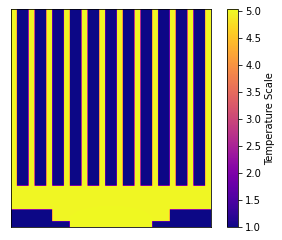


Average T, difference from 1000 runs ago:
 5.000928182594561 9.412334428482438e-05
T:     pr     |     cs     |      hs      |
 5.02357014913769 5.012059358043496 4.999471553751586


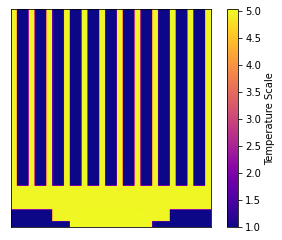


Average T, difference from 1000 runs ago:
 5.001000449219007 7.2266624446371e-05
T:     pr     |     cs     |      hs      |
 5.025823690395468 5.013992654171572 4.99932322168292


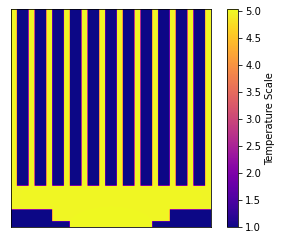


Average T, difference from 1000 runs ago:
 5.001064646885687 6.419766667953297e-05
T:     pr     |     cs     |      hs      |
 5.027966637944832 5.015867103651949 4.99918010168876


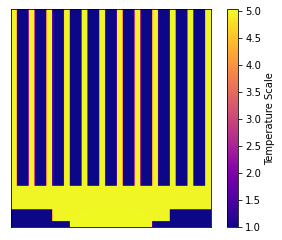


Average T, difference from 1000 runs ago:
 5.001126450027146 6.180314145964871e-05
T:     pr     |     cs     |      hs      |
 5.030024547141963 5.017692396175265 4.99904337553566


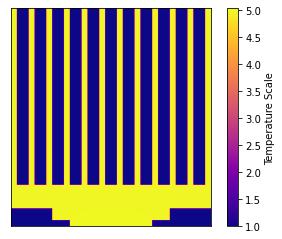


Average T, difference from 1000 runs ago:
 5.0011882795867 6.182955955402747e-05
T:     pr     |     cs     |      hs      |
 5.032011790007176 5.019474235699413 4.998913433839779


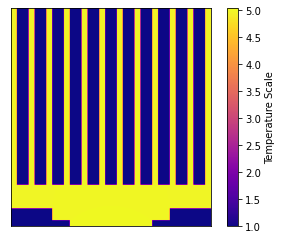


Average T, difference from 1000 runs ago:
 5.00125126849565 6.298890894917974e-05
T:     pr     |     cs     |      hs      |
 5.033937651676987 5.021216574421448 4.998790391385499


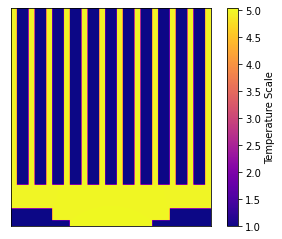


Average T, difference from 1000 runs ago:
 5.001316044050078 4.001316044050078


In [ ]:
from Updates import calc_update_shared_bdd, heat_sinc_boundary, initialise_boundary
from Updates import update_with_source, update_without_source, np, update_boundary_convection

q = 0.5*1e9 # W/m^3
T_a = 293 # K
K_si = 150 # W/mK
K_ceramic = 230 # W/mK
K_alu = 250 # W/mK
h = 1e-4 # m         

#%% initialising the system

ambient = 5

# set up the processor

vol_pr = 140*10

top = np.array([ambient for i in range(140)])
bottom = top.copy()
left = np.array([ambient for i in range(10)])
right = left.copy()

T_0_pr, T_k_pr = initialise_boundary(top, left, right, bottom, ambient,[ambient,ambient,ambient,ambient])

# set up the case

vol_cs = 200*20

top = np.array([ambient for i in range(200)])
bottom = top.copy()
left = np.array([ambient for i in range(20)])
right = left.copy()

T_0_cs, T_k_cs = initialise_boundary(top, left, right, bottom, ambient,[ambient,ambient,ambient,ambient])


# set up the main body of the heat sinc (34x4)

sinc_length = 340
spacing = 20
vol_sinc = sinc_length*40

top = np.array([ambient for i in range(sinc_length)])
bottom = top.copy()
left = np.array([ambient for i in range(40)])
right = left.copy()

T_0_hs, T_k_hs = initialise_boundary(top, left, right, bottom, ambient,[ambient,ambient,ambient,ambient])

# set up fins for heat sinc

fin_length = 300

top = np.array([ambient for i in range(10)])
bottom = top.copy()
left = np.array([ambient for i in range(fin_length)])
right = left.copy()

n_fins = int((sinc_length+spacing)/(10+spacing))

vol_fins = n_fins*10*fin_length
fin_0, fin_k = initialise_boundary(top, left, right, bottom, ambient,[ambient,ambient,ambient,ambient])
T_0_fn = np.array([fin_0 for i in range(n_fins)])
T_k_fn = np.array([fin_k for i in range(n_fins)])


#%% plot to see initial system

import Plotting as plot

plot.plot_whole_system(T_k_cs, T_k_pr, T_k_fn, T_k_hs, 0)

#%% fist boundary update: nat convection

T_0_pr_update, T_0_cs_update = update_boundary_convection(T_k_pr, K_si), update_boundary_convection(T_k_cs, K_ceramic)
T_0_hs_update = update_boundary_convection(T_k_hs, K_alu)
T_0_fn_update = T_0_fn.copy()

for fin_0, fin_k in zip(T_0_fn_update, T_k_fn):
    fin_0 = update_boundary_convection(np.matrix(fin_k), K_alu)
    
#%% fist boundary update: shared boundies

T_0_pr_update, T_0_cs_update = calc_update_shared_bdd(T_k_pr[2].A1, T_k_cs[-3].A1, K_si, K_ceramic, T_0_pr_update, T_0_cs_update)
T_0_cs_update, T_0_hs_update = calc_update_shared_bdd(T_k_cs[2].A1, T_k_hs[-3].A1, K_ceramic, K_alu, T_0_cs_update, T_0_hs_update)

T_above_list = np.array([fin_k[-3] for fin_k in T_k_fn])
T_below = T_k_hs[-3].A1
T_0_hs_update, T_0_fn_update = heat_sinc_boundary(T_below, T_above_list, T_0_hs_update, T_0_fn_update)

#%% fist inside update

T_k_pr_update = update_with_source(T_k_pr, T_0_pr_update, q, h)
T_k_cs_update = update_without_source(T_k_cs, T_0_cs_update)
T_k_hs_update = update_without_source(T_k_hs, T_0_hs_update)

T_k_fn_update = T_k_fn.copy()
for fin_0, fin_k in zip(T_0_fn_update, T_k_fn_update):
    fin_k = update_without_source(np.matrix(fin_k), fin_0)

#%% iterations!!!

from Calculators import average_temp

ambient = 1

avT_k_1 = 1.0059450123656382
diff_array = []
av_array = []

for i in range(10000):
    
    # update boundaries convection
    T_0_pr_update, T_0_cs_update = update_boundary_convection(T_k_pr_update, K_si), update_boundary_convection(T_k_cs_update, K_ceramic)
    T_0_hs_update = update_boundary_convection(T_k_hs_update, K_alu)
    T_0_fn_update = np.array([update_boundary_convection(np.matrix(fin_k), K_alu) for fin_k in T_k_fn_update])

    
    # update boudaries shared
    T_0_pr_update, T_0_cs_update = calc_update_shared_bdd(T_k_pr_update[2].A1, T_k_cs_update[-3].A1, K_si, K_ceramic, T_0_pr_update, T_0_cs_update)
    T_0_cs_update, T_0_hs_update = calc_update_shared_bdd(T_k_cs_update[2].A1, T_k_hs_update[-3].A1, K_ceramic, K_alu, T_0_cs_update, T_0_hs_update)
    T_above_list = np.array([fin_k[-3] for fin_k in T_k_fn_update])
    T_below = T_k_hs_update[-3].A1
    T_0_hs_update, T_0_fn_update = heat_sinc_boundary(T_below, T_above_list, T_0_hs_update, T_0_fn_update)
    
    # update inside temps
    T_k_pr_update = update_with_source(T_k_pr_update, T_0_pr_update, q, h)
    T_k_cs_update = update_without_source(T_k_cs_update, T_0_cs_update)
    T_k_hs_update = update_without_source(T_k_hs_update, T_0_hs_update)
    T_k_fn_update = np.array([update_without_source(np.matrix(fin_k), fin_0) for fin_0, fin_k in zip(T_0_fn_update, T_k_fn_update)])

    
    if i%1000 == 0:
        average_T_pr = average_temp(T_k_pr_update)
        average_T_cs = average_temp(T_k_cs_update)
        average_T_fn = sum([average_temp(np.matrix(T_k)) for T_k in T_k_fn_update])/len(T_k_fn_update)
        average_T_hs = average_temp(T_k_cs_update)
        
        average_fin_hs = (vol_fins*average_T_fn + vol_sinc*average_T_hs)/(vol_fins+vol_sinc)
        
        print('T:     pr     |     cs     |      hs      |\n', average_T_pr, average_T_cs, average_fin_hs)
        
        plot.plot_whole_system(T_k_cs_update, T_k_pr_update, T_k_fn_update, T_k_hs_update, ambient)    
        
        avT_k = (vol_fins*average_T_fn + vol_sinc*average_T_hs + vol_cs*average_T_cs + vol_pr* average_T_pr)/(vol_fins+vol_sinc+vol_cs+vol_pr)
        diff = avT_k-avT_k_1
        print('\nAverage T, difference from 1000 runs ago:\n',avT_k, diff)
        avT_k_1 = avT_k

    if i%1000 == 0 and i >= 2000:

        diff_array.append(diff)
        av_array.append(avT_k)


#%%

avT_k_1 = ambient
diff_array_big = []
av_array_big = []
every = 5000

for i in range(500000):
    
    # update boundaries convection
    T_0_pr_update, T_0_cs_update = update_boundary_convection(T_k_pr_update, K_si), update_boundary_convection(T_k_cs_update, K_ceramic)
    T_0_hs_update = update_boundary_convection(T_k_hs_update, K_alu)
    T_0_fn_update = np.array([update_boundary_convection(np.matrix(fin_k), K_alu) for fin_k in T_k_fn_update])

    
    # update boudaries shared
    T_0_pr_update, T_0_cs_update = calc_update_shared_bdd(T_k_pr_update[2].A1, T_k_cs_update[-3].A1, K_si, K_ceramic, T_0_pr_update, T_0_cs_update)
    T_0_cs_update, T_0_hs_update = calc_update_shared_bdd(T_k_cs_update[2].A1, T_k_hs_update[-3].A1, K_ceramic, K_alu, T_0_cs_update, T_0_hs_update)
    T_above_list = np.array([fin_k[-3] for fin_k in T_k_fn_update])
    T_below = T_k_hs_update[-3].A1
    T_0_hs_update, T_0_fn_update = heat_sinc_boundary(T_below, T_above_list, T_0_hs_update, T_0_fn_update)
    
    # update inside temps
    T_k_pr_update = update_with_source(T_k_pr_update, T_0_pr_update, q, h)
    T_k_cs_update = update_without_source(T_k_cs_update, T_0_cs_update)
    T_k_hs_update = update_without_source(T_k_hs_update, T_0_hs_update)
    T_k_fn_update = np.array([update_without_source(np.matrix(fin_k), fin_0) for fin_0, fin_k in zip(T_0_fn_update, T_k_fn_update)])

    
    if i%every == 0:
        average_T_pr = average_temp(T_k_pr_update)
        average_T_cs = average_temp(T_k_cs_update)
        average_T_fn = sum([average_temp(np.matrix(T_k)) for T_k in T_k_fn_update])/len(T_k_fn_update)
        average_T_hs = average_temp(T_k_cs_update)
        
        average_fin_hs = (vol_fins*average_T_fn + vol_sinc*average_T_hs)/(vol_fins+vol_sinc)
        
        print('T:     pr     |     cs     |      hs      |\n', average_T_pr, average_T_cs, average_fin_hs)
        
        plot.plot_whole_system(T_k_cs_update, T_k_pr_update, T_k_fn_update, T_k_hs_update, ambient)    
        
        avT_k = (vol_fins*average_T_fn + vol_sinc*average_T_hs + vol_cs*average_T_cs + vol_pr* average_T_pr)/(vol_fins+vol_sinc+vol_cs+vol_pr)
        diff = avT_k-avT_k_1
        print('\nAverage T, difference from 1000 runs ago:\n',avT_k, diff)
        avT_k_1 = avT_k

    if i%every == 0 and i >= 17000:

        diff_array_big.append(diff)
        av_array_big.append(avT_k)




In [ ]:
avT_k_1 = ambient
diff_array = []
av_array = []

ambient = 1

for i in range(10000):
    
    # update boundaries convection
    T_0_pr_update, T_0_cs_update = update_boundary_convection(T_k_pr_update, K_si), update_boundary_convection(T_k_cs_update, K_ceramic)
    T_0_hs_update = update_boundary_convection(T_k_hs_update, K_alu)
    for fin_0, fin_k in zip(T_0_fn_update, T_k_fn_update):
        fin_0 = update_boundary_convection(np.matrix(fin_k), K_alu)
    
    # update boudaries shared
    T_0_pr_update, T_0_cs_update = calc_update_shared_bdd(T_k_pr_update[2].A1, T_k_cs_update[-3].A1, K_si, K_ceramic, T_0_pr_update, T_0_cs_update)
    T_0_cs_update, T_0_hs_update = calc_update_shared_bdd(T_k_cs_update[2].A1, T_k_hs_update[-3].A1, K_ceramic, K_alu, T_0_cs_update, T_0_hs_update)
    T_above_list = np.array([fin_k[-3] for fin_k in T_k_fn_update])
    T_below = T_k_hs_update[-3].A1
    T_0_hs_update, T_0_fn_update = heat_sinc_boundary(T_below, T_above_list, T_0_hs_update, T_0_fn_update)
    
    # update inside temps
    T_k_pr_update = update_with_source(T_k_pr_update, T_0_pr_update, q, h)
    T_k_cs_update = update_without_source(T_k_cs_update, T_0_cs_update)
    T_k_hs_update = update_without_source(T_k_hs, T_0_hs_update)
    for fin_0, fin_k in zip(T_0_fn_update, T_k_fn_update):
        fin_k = update_without_source(np.matrix(fin_k), fin_0)
    
    if i%1000 == 0:
        average_T_pr = average_temp(T_k_pr_update)
        average_T_cs = average_temp(T_k_cs_update)
        average_T_fn = sum([average_temp(np.matrix(T_k)) for T_k in T_k_fn_update])/len(T_k_fn_update)
        average_T_hs = average_temp(T_k_cs_update)
        
        average_fin_hs = (vol_fins*average_T_fn + vol_sinc*average_T_hs)/(vol_fins+vol_sinc)
        
        print('T:     pr     |     cs     |      hs      |\n', average_T_pr, average_T_cs, average_fin_hs)
        
        plot.plot_whole_system(T_k_cs_update, T_k_pr_update, T_k_fn_update, T_k_hs_update, ambient)    
        
        avT_k = (vol_fins*average_T_fn + vol_sinc*average_T_hs + vol_cs*average_T_cs + vol_pr* average_T_pr)/(vol_fins+vol_sinc+vol_cs+vol_pr)
        diff = avT_k-avT_k_1
        print('\nAverage T, difference from 1000 runs ago:\n',avT_k, diff)
        avT_k_1 = avT_k

    if i%1000 == 0 and i >= 2000:

        diff_array.append(diff)
        av_array.append(avT_k)

